## Model variant BC1 for UK data



In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dill
import time
import pandas as pd

In [2]:
# specification of the model structure for pyross

full_model_spec = {
    'classes': ["S", "E", "A", "Ia", "Is1", "Is2", "Im", "R", "AQ", "IaQ", "Is1Q", "Is2Q", "ImQ", "RQ"],
    'S': {'linear': [['S', '-kE', 'overdispersion_general'], ['S', '-kA', 'overdispersion_general']],
          'infection': [['A', '-beta', 'overdispersion_infection'],
                        ['Ia', '-beta', 'overdispersion_infection'],
                        ['Is1', '-beta', 'overdispersion_infection'],
                        ['Is2', '-beta_late', 'overdispersion_infection']],
          'finite-resource': [['S', '-tau', 'pi_a', 'p_falsepos', 'overdispersion_testing']]},
    'E': {'linear': [['S', 'kE', 'overdispersion_general'], ['E', '-gammaE', 'overdispersion_general']],
          'infection': [['A', 'beta', 'overdispersion_infection'],
                        ['Ia', 'beta', 'overdispersion_infection'],
                        ['Is1', 'beta', 'overdispersion_infection'],
                        ['Is2', 'beta_late', 'overdispersion_infection']],
          'finite-resource': [['E', '-tau', 'pi_a', 'p_trueposE', 'overdispersion_testing']]},
    'A': {'linear': [['S', 'kA', 'overdispersion_general'],
                         ['E', 'gammaE', 'overdispersion_general'],
                         ['A', '-alphabar*gammaA', 'overdispersion_general'],
                         ['A', '-alpha*gammaA', 'overdispersion_general']],
              'infection': [],
              'finite-resource': [['A', '-tau', 'pi_a', 'p_truepos', 'overdispersion_testing']]},
    'Ia': {'linear': [['A', 'alpha*gammaA', 'overdispersion_general'], ['Ia', '-gammaIa', 'overdispersion_general']],
               'infection': [],
               'finite-resource': [['Ia', '-tau', 'pi_a', 'p_truepos', 'overdispersion_testing']]},
    'Is1': {'linear': [['A', 'alphabar*gammaA', 'overdispersion_general'],
                           ['Is1', '-cfrbar*gammaIs', 'overdispersion_general'],
                           ['Is1', '-cfr*gammaIs', 'overdispersion_general']],
                'infection': [],
                'finite-resource': [['Is1', '-tau', 'pi_s', 'p_truepos', 'overdispersion_testing']]},
    'Is2': {'linear': [['Is1', 'cfr*gammaIs', 'overdispersion_general'],
                           ['Is2', '-cfrbar*gammaIs', 'overdispersion_general'],
                           ['Is2', '-cfr*gammaIs', 'overdispersion_general']],
                'infection': [],
                'finite-resource': [['Is2', '-tau', 'pi_s2', 'p_truepos', 'overdispersion_testing']]},
    'Im': {'linear': [['Is2', 'cfr*gammaIs', 'overdispersion_general']],
               'infection': [],
               'finite-resource': [['Im', '-tau', 'pi_m', 'p_truepos', 'overdispersion_deaths']]},
    'R': {'linear': [['Ia', 'gammaIa', 'overdispersion_general'],
                         ['Is1', 'cfrbar*gammaIs', 'overdispersion_general'],
                         ['Is2', 'cfrbar*gammaIs', 'overdispersion_general']],
              'finite-resource': [['R', '-tau', 'pi_a', 'p_falsepos', 'overdispersion_testing']]},
    'AQ': {'linear': [    ['AQ', '-alphabar*gammaA', 'overdispersion_general'],
                          ['AQ', '-alpha*gammaA', 'overdispersion_general']],
               'finite-resource': [['A', 'tau', 'pi_a', 'p_truepos', 'overdispersion_testing']]},
    'IaQ': {'linear': [['AQ', 'alpha*gammaA', 'overdispersion_general'], ['IaQ', '-gammaIa', 'overdispersion_general']],
                'finite-resource': [['Ia', 'tau', 'pi_a', 'p_truepos', 'overdispersion_testing']]},
    'Is1Q': {'linear': [['AQ', 'alphabar*gammaA', 'overdispersion_general'],
                            ['Is1Q', '-cfrbar*gammaIs', 'overdispersion_general'],
                            ['Is1Q', '-cfr*gammaIs', 'overdispersion_general']],
                 'finite-resource': [['Is1', 'tau', 'pi_s', 'p_truepos', 'overdispersion_testing']]},
    'Is2Q': {'linear': [['Is1Q', 'cfr*gammaIs', 'overdispersion_general'],
                            ['Is2Q', '-cfrbar*gammaIs', 'overdispersion_general'],
                            ['Is2Q', '-cfr*gammaIs', 'overdispersion_deaths']],
                 'finite-resource': [['Is2', 'tau', 'pi_s2', 'p_truepos', 'overdispersion_testing']]},
    'ImQ': {'linear': [['Is2Q', 'cfr*gammaIs', 'overdispersion_deaths']],
                'finite-resource': [['Im', 'tau', 'pi_m', 'p_truepos', 'overdispersion_deaths']]},
    'RQ': {'linear': [['IaQ', 'gammaIa', 'overdispersion_general'],
                          ['Is1Q', 'cfrbar*gammaIs', 'overdispersion_general'],
                          ['Is2Q', 'cfrbar*gammaIs', 'overdispersion_general']],
               'finite-resource': [['R', 'tau', 'pi_a', 'p_falsepos', 'overdispersion_testing']]},
    }

### Load British data

In [3]:
# case numbers

# downloaded from https://coronavirus.data.gov.uk/details/download
cases_raw=pd.read_csv('data/specimenDate_ageDemographic-stacked.csv', sep=',',header=0)


agegroups_full=['0_4', '5_9', '10_14', '15_19', '20_24', '25_29', '30_34', '35_39', '40_44', '45_49', 
               '50_54', '55_59', '60_64', '65_69', '70_74', '75_79', '80_84', '85_89', '90+']

dates=sorted(cases_raw['date'].unique())

cases_grouped=cases_raw.groupby(['date','age'])['newCasesBySpecimenDate'].sum()

cases_full=np.zeros((len(dates),len(agegroups_full)))

for i in range(len(dates)):
    for j in range(len(agegroups_full)):
        cases_full[i,j]=cases_grouped[dates[i],agegroups_full[j]]

# coarse grain the data to the following 7 age groups
agegroups=['0-14', '15-29', '30-44', '45-64', '65-74', '75-84', '85+']
cases_daily=np.vstack([np.sum(cases_full[:,:3],axis=1),
                 np.sum(cases_full[:,3:6],axis=1),
                 np.sum(cases_full[:,6:9],axis=1),
                 np.sum(cases_full[:,9:13],axis=1),
                 np.sum(cases_full[:,13:15],axis=1),
                 np.sum(cases_full[:,15:17],axis=1),
                 np.sum(cases_full[:,17:],axis=1)])
cases_daily=np.transpose(cases_daily)

In [4]:
# mortality data from ONS
# Downloaded from https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales
deaths_raw=pd.read_csv('data/UK-deaths.csv', sep=',',index_col=0,header=None).T
deaths_raw['Week ended']=pd.to_datetime(deaths_raw['Week ended'], format='%d-%b-%y')
agegroups_deaths=['0-14', '15-44', '45-64', '65-74', '75-84', '85+'] # note that age groups 15-29 and 30-44 are joined into one
deaths=np.array(deaths_raw)[:-3,2:].astype(np.float)  # skip last 3 weeks (incomplete, to be replaced by PHE data)
deaths[:,0] += np.array(deaths_raw)[:-3,1].astype(np.float) # join under 1 year and 1-14

In [5]:
# mortality data from PHE
# Downloaded from https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newDeaths28DaysByDeathDate&format=csv
# not age-structured !
deaths_PHE=pd.read_csv('data/UK-deaths-tot.csv')

deaths_PHE['date']=pd.to_datetime(deaths_PHE['date'], format='%Y-%m-%d')
deaths_PHE=deaths_PHE.sort_values(by='date')

deaths_PHE=np.array(deaths_PHE['newDeaths28DaysByDeathDate'])


In [6]:
# Match starting dates of datasets and calculate cumulative numbers

# cases: 1st row Thu 2020-01-30
# deaths: 1st row week ending Fri 2020-01-03
# deaths_PHE: 1st row week ending Sat 2020-02-29
tstart = 10 # 0 = start with cases/deaths in week ending 2020-01-03

# coarse grain to weekly data
cases=np.array([np.sum(cases_daily[(n*7+2):(n*7+7+2),:],axis=0) for n in range((np.shape(cases_daily)[0]-2)//7)])
cases=cases[(tstart-5):]
cases0=np.sum(cases_daily[:((tstart-5)*7+2)],axis=0)
cumcases = np.cumsum(np.vstack([cases0,cases]),axis=0)[1:]


deaths0=np.sum(deaths[:tstart],axis=0)
deaths = deaths[tstart:]
cumdeaths = np.cumsum(np.vstack([deaths0,deaths]),axis=0)[1:]
deaths_tot = np.sum(cumdeaths,axis=1)

deaths_PHE_weekly = np.array([np.sum(deaths_PHE[(n*7):(n*7+7)]) for n in range((len(deaths_PHE))//7)])
deaths_tot2=np.cumsum(deaths_PHE_weekly)[(tstart-9):]
deaths_PHE_weekly=deaths_PHE_weekly[(tstart-9):]

# fill remaining weeks of deaths_tot with deaths_tot2
deaths_tot=np.hstack([deaths_tot,deaths_tot[-1]+np.cumsum(deaths_PHE_weekly[len(deaths_tot):])])

# with tstart=10, we have cases0 the number of cases before 2020-03-07, cases[0] is number of new cases in week no. 9, from 2020-03-07 to 2020-03-13
start_date = '2020-03-07'
dates = pd.date_range(start_date, periods=len(cumcases), freq="W-fri")

In [7]:
# Load UK population data and match age structure

pop_uk=np.array(np.array(pd.read_csv('data/uk-pop.csv', sep=',',header=0, index_col=0)),dtype=float)
Ni_raw=pop_uk[:91,0]+pop_uk[92:-1,0]
Ni_raw=np.reshape(Ni_raw,len(Ni_raw))
N  = np.sum(Ni_raw)  ## total population

Ni_2007=pop_uk[:91,1]+pop_uk[92:-1,1]
Ni_2007=np.reshape(Ni_2007,len(Ni_2007))
N_2007  = np.sum(Ni_2007)  ## total population

ages = [range(0,15),range(15,30),range(30,45),range(45,65),range(65,75),range(75,85),range(85,91)]
M=len(ages)
Ni=np.zeros(M)
for i in range(M):
    Ni[i]=np.sum(Ni_raw[ages[i]])

### Set up contact matrices

In [8]:
# Get individual contact matrices
# from 10.1371/journal.pcbi.1002673 [including weights]
# extra factor 138486 to match normalisation of contact matrices used elsewhere
CCH, CCW, CCS, CCO = pyross.contactMatrix.UK(source='fumanelliEtAl')

CCH *= 0.2967389401537168 * 138486
CCW *= 0.21047072827767516 * 138486
CCS *= 0.18401161228369423 * 138486
CCO *= 0.30877872343486956 * 138486

CCtot = CCH +  CCW +  CCS +  CCO

MCM=CCH.shape[0]


Note: these contact matrices are already symmetric, in the form $\tilde C_{ij}=N_iC_{ij}$

In [9]:
# Project contact matrices from 2007 to 2020
# Method M2 from  https://doi.org/10.1371/journal.pcbi.1006638

correction = np.zeros((MCM,MCM))

for i in range(MCM):
    for j in range(MCM):
        correction[i,j] = N_2007*Ni_raw[i]*Ni_raw[j]/(N*Ni_2007[i]*Ni_2007[j])

CCH = CCH*correction
CCS = CCS*correction
CCW = CCW*correction
CCO = CCO*correction
CCtot = CCtot*correction

In [10]:
# Reduce matrices to ONS age structure

CH=np.zeros((M,M))
CS=np.zeros((M,M))
CW=np.zeros((M,M))
CO=np.zeros((M,M))


ages = [range(0,15),range(15,30),range(30,45),range(45,65),range(65,75),range(75,85),range(85,90)]
for i in range(M):
    for j in range(M):
        CH[i,j] = np.sum(CCH[ages[i],:][:,ages[j]])/Ni[i]
        CS[i,j] = np.sum(CCS[ages[i],:][:,ages[j]])/Ni[i]
        CW[i,j] = np.sum(CCW[ages[i],:][:,ages[j]])/Ni[i]
        CO[i,j] = np.sum(CCO[ages[i],:][:,ages[j]])/Ni[i]
        
Ctot = CH+CS+CW+CO
                             


total


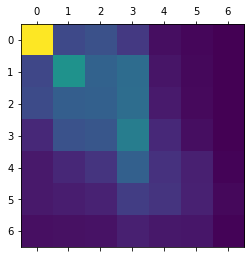

home


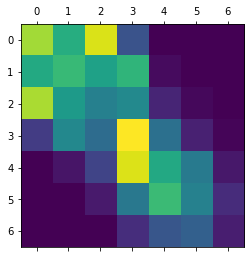

school


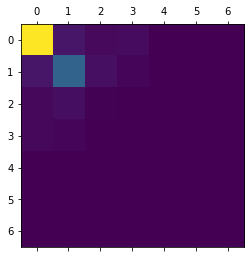

work


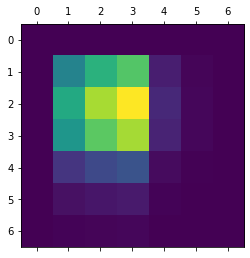

other


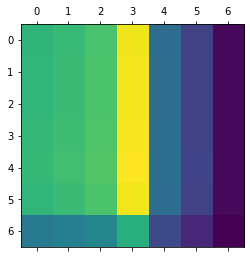

In [11]:
# inspect contact matrices
print('total')
plt.matshow(Ctot)
plt.show()
print('home')
plt.matshow(CH)
plt.show()
print('school')
plt.matshow(CS)
plt.show()
print('work')
plt.matshow(CW)
plt.show()
print('other')
plt.matshow(CO)
plt.show()

In [12]:
# helper function for plotting with axis labeled by months
def set_month_axis():
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(0, 13, 2)))

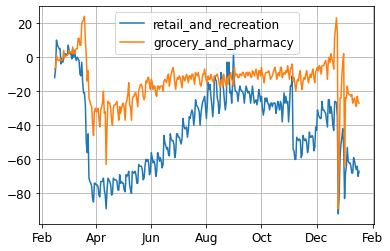

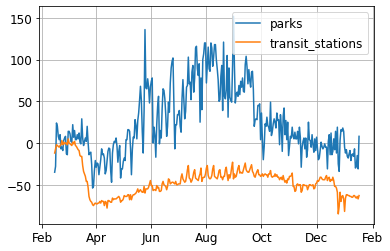

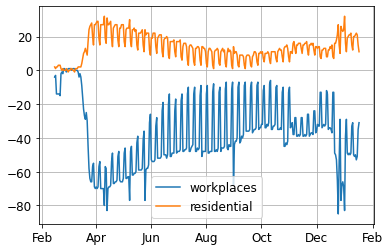

In [13]:
# Inspect google mobility data
# helps us setting up the genral shape of the intervention function

# downloaded from https://www.google.com/covid19/mobility/

gmd = pd.read_csv('data/2020_GB_Region_Mobility_Report.csv')
gmd = gmd[pd.isnull(gmd['sub_region_1'])]
c1 = gmd['retail_and_recreation_percent_change_from_baseline']
c2 = gmd['grocery_and_pharmacy_percent_change_from_baseline']
c3 = gmd['parks_percent_change_from_baseline']
c4 = gmd['transit_stations_percent_change_from_baseline']
c5 = gmd['workplaces_percent_change_from_baseline']
c6 = gmd['residential_percent_change_from_baseline']
tt = pd.to_datetime(gmd['date'], format='%Y-%m-%d')

plt.rcParams.update({'font.size': 12})
plt.plot(tt,c1,label='retail_and_recreation')
plt.plot(tt,c2,label='grocery_and_pharmacy')
plt.grid()
plt.legend()
set_month_axis()
plt.show()
plt.plot(tt,c3,label='parks')
plt.plot(tt,c4,label='transit_stations')
plt.grid()
plt.legend()
set_month_axis()
plt.show()
plt.plot(tt,c5,label='workplaces')
plt.plot(tt,c6,label='residential')
plt.grid()
plt.legend()
set_month_axis()
plt.show()

In [14]:
# Set up interventions

# combine all contact matrices and vary only compliance and shielding

generator = pyross.contactMatrix.ContactMatrixFunction(0*Ctot, 0*Ctot, 0*Ctot, Ctot)

times= [2, 3, 20, 32, 35, 39, 44] # temporal boundaries between different contact-behaviour


# prefactors for CW, CS, CO:
def intervention_fun(t, M, a2=1, a3=1, a4=1, a5=1, a6=1, a7=1, a8=1, a9=1, a10=1, s2=0, s4=0, s5=0, s6=0, s7=0, s8=0, s9=0, s10=0, sh45=0, sh65=0, t_autumn=25, width_autumn=2, t3=32):
    
    shielding = np.array([0,0,0,sh45,sh65,sh65,1])
    shielding /= np.max(shielding) # avoid negative contact frequencies
    
    # before intervention
    a = 1 
    s = 0
    if t > times[0] and t <= times[1]:
        a = 1 + (t-times[0])/(times[1]-times[0]) * (a2 - 1)
        s = s2
    if t > times[1] and t <= times[2]:
        a = a2 * (1 + (t-times[1])/(times[2]-times[1]) * (a3 - 1)) # full lockdown
        s = s2 + (t-times[1])/(times[2]-times[1]) * (s4 - s2)
    if t > times[2] and t <= times[4]:
        a = (a2 * a3 * a4) + (a2 * a3 * a4 * a5 - a2 * a3 * a4) * (0.5 *np.tanh((t-t_autumn)/width_autumn) + 0.5) # shops open again & start of autumn
        s = s5
    if t > t3 and t <= times[4]: 
        a *= a6 #  local (tiered) lockdowns
        s *= s6 
    if t > times[4] and t <= times[5]: 
        a = a2 * a3 * a4 *a5 * a6 * a7 * (1 + (t-times[4])/(times[5]-times[4]) * (a8 - 1)) # 2nd full lockdown
        s = s7 + (t-times[4])/(times[5]-times[4]) * (s8 - s7)
    if t > times[5] and t <= times[6]:
        a = a2 * a3 * a4 *a5 * a6 * a7 * a8 *a9 # tiered lockdown
        s = s9
    if t > times[6]:
        a = a2 * a3 * a4 *a5 * a6 * a7 * a8 * a9 * a10 # full lockdown
        s = s10
        
    
    aW_full = np.zeros((2, M)) 
    aS_full = np.zeros((2, M))
    aO_full = a * np.array([1-s*shielding,1-s*shielding])
    return aW_full, aS_full, aO_full




# generate corresponding contact matrix function
contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                        a2=1, a3=1, a4=1, a5=1, a6=1, a7=1, a8=1, a9=1, a10=1,s2=0, s4=0, s5=0, s6=0, s7=0, s8=0, s9=0, s10=0, sh45=0, sh65=0, t_autumn=29, width_autumn=2, t3=32)

In [15]:
# function to plot intervention function
def intervention_plot(intervention_fun, Tf, **kwargs):
    t = np.linspace(0,Tf,1024)
    end_date=pd.to_datetime(start_date, format='%Y-%m-%d')+ pd.DateOffset(weeks=Tf)
    ddates = pd.date_range(start_date, end_date, periods=len(t))
    a_vec = np.zeros([len(t),M]) 
    print(kwargs)
    for i in range(len(t)):
        a_vec[i,:] = intervention_fun(t[i], M, **kwargs)[2][0]
        #print(t[i])
        #print(intervention_fun(t[i], M, **kwargs))
    labels = [' age 0-44','45-64','65-84','85+']
    cmptmt = [0, 3, 5, 6]
    colors=['tab:green','tab:red','tab:brown','tab:pink']
    for i in range(4):
        plt.plot(ddates,a_vec[:,cmptmt[i]],label=labels[i],color=colors[i])
    plt.legend()
    plt.grid()
    set_month_axis()
    plt.show()
    

{'a2': 0.3, 'a3': 1.3, 'a4': 1.3, 'a5': 1.3, 'a6': 0.75, 'a7': 0.5, 'a8': 2, 'a9': 1.2, 'a10': 0.5, 's2': 0, 's4': 0.8, 's5': 0.5, 's6': 0.5, 's7': 0.5, 's8': 0.3, 's9': 0.2, 's10': 0.1, 'sh45': 0.5, 'sh65': 0.7}


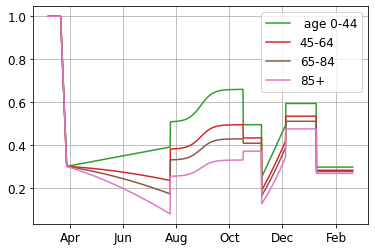

In [16]:
# example plot of intervention function
intervention_plot(intervention_fun, 50, a2=0.3, a3=1.3, a4=1.3, a5=1.3, a6=0.75, a7=.5, a8=2, a9=1.2, a10=0.5, s2=0, s4=0.8, s5=0.5, s6=0.5, s7=0.5, s8=0.3, s9=0.2, s10=0.1, sh45=0.5, sh65=0.7)

In [17]:
# time-dependent parameter mapping

# maps the inferred parameters to time dependent internal parameters of the model

def parameter_mapping(input_parameters, t):
    
    # time-dependent change of mortality (note: cfr is what is referred to as "SIFR" in paper)
    cfr_scale = 1 + (input_parameters['cfr_change'] - 1) * (0.5 * np.tanh((t-input_parameters['t_cfr_change'])/input_parameters['width_cfr_change']) + 0.5)
 
    cfr = np.array([input_parameters['cfr0_14'],
                    input_parameters['cfr15_29'],
                    input_parameters['cfr30_64']*cfr_scale,
                    input_parameters['cfr30_64']*cfr_scale,
                    input_parameters['cfr65_74']*cfr_scale,
                    input_parameters['cfr75_84']*cfr_scale,
                    input_parameters['cfr85']*cfr_scale])
    
    # time dependent testing-priority
    if t<7.5: # (no mass testing available)
        pi_a=input_parameters['pi_a_early']
        pi_m=input_parameters['pi_m_early']
        pi_s2=input_parameters['pi_s2_early']
    else:
        pi_a=input_parameters['pi_a_late']
        pi_m=input_parameters['pi_m_late']
        pi_s2=input_parameters['pi_s']
    
    # time dependent overdispersion parameters
    if t<30:
        overdispersion_infection=input_parameters['overdispersion_infection']
        overdispersion_testing=input_parameters['overdispersion_testing']
        overdispersion_deaths=input_parameters['overdispersion_deaths']
    else:
        overdispersion_infection=input_parameters['overdispersion_infection_late']
        overdispersion_testing=input_parameters['overdispersion_testing_late']
        overdispersion_deaths=input_parameters['overdispersion_deaths_late']
    
    output_parameters = {
        'beta' : input_parameters['beta'].copy(),
        'beta_late' : input_parameters['beta'].copy()*input_parameters['beta_late_factor'],
        'gammaE' : input_parameters['gammaE'],
        'alpha*gammaA' : input_parameters['alpha'] * input_parameters['gammaA'], 
        'alphabar*gammaA' : (1 - input_parameters['alpha']) * input_parameters['gammaA'], 
        'gammaIa' : input_parameters['gammaIa'], 
        'cfr*gammaIs' : np.sqrt(cfr) * input_parameters['gammaIs'] ,
        'cfrbar*gammaIs' : (1 - np.sqrt(cfr)) * input_parameters['gammaIs'] ,
        'kE' : input_parameters['kE'],
        'kA' : input_parameters['kA'],
        'p_falsepos' : input_parameters['p_falsepos'],
        'p_truepos'  : input_parameters['p_truepos'],
        'p_trueposE'  : input_parameters['p_trueposE'],
        'pi_a'      : pi_a,
        'pi_s'      : input_parameters['pi_s'],
        'pi_s2'      : pi_s2,
        'pi_m'      : pi_m,
        'tau'       : testRate(t),
        'overdispersion_infection'  : overdispersion_infection,
        'overdispersion_testing'  : overdispersion_testing,
        'overdispersion_general'  : input_parameters['overdispersion_general'],
        'overdispersion_deaths'  : overdispersion_deaths,
        
    }
        
    return output_parameters

### Set up test rate

We combine testing data from three different sources

In [18]:
testdata0 = pd.read_csv('data/full-list-total-tests-for-covid-19.csv')  # ourworldindata.org retrieved 2020-04-16 
testdata0 = testdata0[testdata0['Code']=='GBR']
testdata0['Total tests'] = np.hstack([0,np.diff(testdata0['Total tests'])])
testdata0['Date'] = pd.to_datetime(testdata0['Date'], format='%b %d, %Y')
testdata0 = testdata0.sort_values(by='Date')
testdata0 = testdata0.set_index(['Date'])

In [19]:
testdata1 = pd.read_csv('data/covid-testing-all-observations.csv')  # ourworldindata.org retrieved 2021-01-01
testdata1 = testdata1[testdata1['ISO code']=='GBR']
testdata1['Date']=pd.to_datetime(testdata1['Date'], format='%Y-%m-%d')
testdata1 = testdata1.sort_values(by='Date')
testdata1 = testdata1.set_index(['Date'])

In [20]:
# data from gov.uk, starting 2020-04-21
# https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newPCRTestsByPublishDate&format=csv
testdata2 = pd.read_csv('data/PCR-tests-uk.csv')
testdata2['date']=pd.to_datetime(testdata2['date'], format='%Y-%m-%d')
testdata2 = testdata2.sort_values(by='date')
testdata2 = testdata2.set_index(['date'])

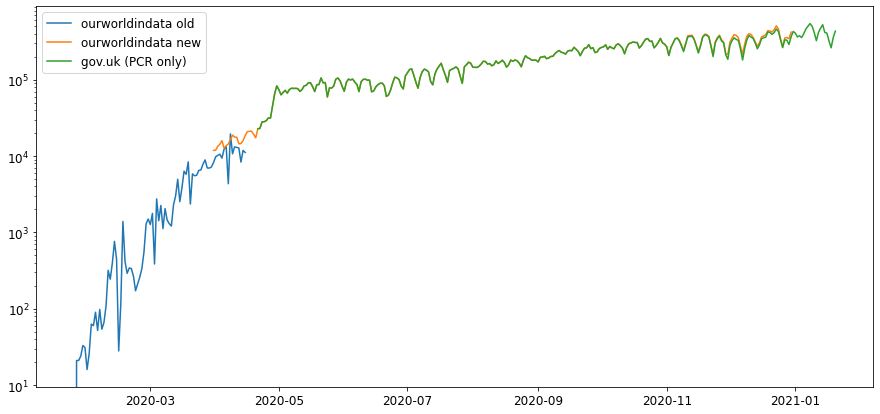

In [21]:
plt.figure(figsize=(15,7))
plt.semilogy(testdata0['Total tests'],label='ourworldindata old')
plt.semilogy(testdata1['Daily change in cumulative total'],label='ourworldindata new')
plt.semilogy(testdata2['newPCRTestsByPublishDate'],label='gov.uk (PCR only)')
plt.legend()

In [22]:
testdata_merged=pd.concat([testdata0['2020-03-07':'2020-03-30']['Total tests'],
                           testdata1['2020-03-31':'2020-04-20']['Daily change in cumulative total'],
                           testdata2['2020-04-21':]['newPCRTestsByPublishDate']])
testdata=np.array(testdata_merged)
testdata_weekly=np.array([np.sum(testdata[(n*7):(n*7+7)],axis=0) for n in range(len(testdata)//7)])

In [23]:
# Tests performed per week

def testRate(t):
    if t >= len(testdata_weekly):
        return testdata_weekly[-1]
    else:
        return testdata_weekly[np.int(t)]

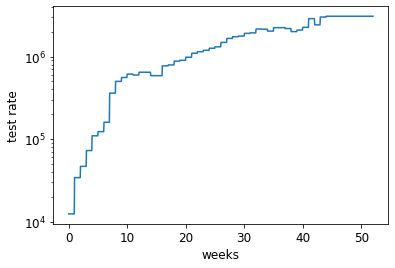

In [24]:
tt=np.linspace(0,52,1024)
plt.semilogy(tt,[testRate(ttt) for ttt in tt])
plt.xlabel('weeks')
plt.ylabel('test rate')
plt.show()

### Function to plot everything of interest

In [25]:
def plot_all(data, parameters):
    # plot the data and obtain the epidemic curve
    
    Si  = model.model_class_data('S', data)
    Ei  = model.model_class_data('E', data)
    Ai  = model.model_class_data('A', data)
    Iai = model.model_class_data('Ia', data)
    Is1i = model.model_class_data('Is1', data)
    Is2i = model.model_class_data('Is2', data)
    Imi = model.model_class_data('Im', data)
    Ri  = model.model_class_data('R', data)
    AiQ  = model.model_class_data('AQ', data)
    IaiQ = model.model_class_data('IaQ', data)
    Is1iQ = model.model_class_data('Is1Q', data)
    Is2iQ = model.model_class_data('Is2Q', data)
    ImiQ = model.model_class_data('ImQ', data)
    RiQ  = model.model_class_data('RQ', data)
    NiQ  = AiQ+IaiQ+Is1iQ+Is2iQ+ImiQ+RiQ
    
    S  = np.sum(model.model_class_data('S', data), axis=1)
    E  = np.sum(model.model_class_data('E', data), axis=1)
    A  = np.sum(model.model_class_data('A', data), axis=1)
    Ia = np.sum(model.model_class_data('Ia', data), axis=1)
    Is1 = np.sum(model.model_class_data('Is1', data), axis=1)
    Is2 = np.sum(model.model_class_data('Is2', data), axis=1)
    Im = np.sum(model.model_class_data('Im', data), axis=1)
    R  = np.sum(model.model_class_data('R', data), axis=1)
    AQ  = np.sum(model.model_class_data('AQ', data), axis=1)
    IaQ = np.sum(model.model_class_data('IaQ', data), axis=1)
    Is1Q = np.sum(model.model_class_data('Is1Q', data), axis=1)
    Is2Q = np.sum(model.model_class_data('Is2Q', data), axis=1)
    ImQ = np.sum(model.model_class_data('ImQ', data), axis=1)
    RQ  = np.sum(model.model_class_data('RQ', data), axis=1)
    NQ  = AQ+IaQ+Is1Q+Is2Q+ImQ+RQ


    
    dates = pd.date_range(start_date, periods=len(data["t"]), freq="W-sun")
    t = dates
    Tf_plot = len(t)-1
    
    
    fig = plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 18})

    plt.subplot(3, 2, 1)
    set_month_axis()

    plt.plot(t, (A+Ia+Is1+Is2+AQ+IaQ+Is1Q+Is2Q)/N, label="infected")
    plt.plot(t, (AQ+IaQ+Is1Q+Is2Q)/N, label="quarantined")
    
    plt.legend(fontsize=18); plt.grid() 
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('Fraction')
    plt.xlabel('Weeks')
    #plt.ylim(0,200000)

    plt.subplot(3, 2, 2)
    set_month_axis()
    tm = t[1:]
    t_fine = np.linspace(0,len(t)-1./7.,len(t)*7)
    dates_fine = pd.date_range(start_date, periods=len(t_fine), freq="D")
    plt.semilogy(dates_fine, [testRate(tt) for tt in t_fine], '--', color="darkgreen", label='weekly total tests', lw=3)
    plt.semilogy(tm, np.diff(NQ), '-', color="#348ABD", label='weekly positive tests (sim)', lw=3)
    plt.semilogy(tm, np.sum(cases[0:Tf_plot,:],axis=1), '--', color="black", label='weekly reported cases (data)', lw=3)
    plt.semilogy(tm, - np.diff(S), '-', color="#A60628", label='true new cases (sim)', lw=3)
    #plt.ylim(10,100000)

    plt.legend(fontsize=14); plt.grid() 
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('Compartment value')
    plt.xlabel('Weeks')

    plt.subplot(3, 2, 3)
    set_month_axis()
    plt.semilogy(t, [np.sum(deaths0), *(deaths_tot[0:(Tf_plot)])], '-', color="black", label='reported deaths (data)', lw=3)
    plt.semilogy(t, ImQ, '-', color="#348ABD", label='reported deaths (sim)', lw=3)
    plt.semilogy(t, Im+ImQ, '--', color='#A60628', label='true deaths (sim)', lw=3)

    plt.legend(fontsize=18); plt.grid() 
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('Compartment value')
    plt.xlabel('Weeks')

    plt.subplot(3, 2, 4)
    set_month_axis()
    plt.semilogy(t, [np.sum(cases0), *(np.sum(cumcases[0:(Tf_plot),:],axis=1))], '-', color="black", label='reported cases (data)', lw=3)
    plt.semilogy(t, NQ, '-', color="#348ABD", label='reported cases (sim)', lw=3)
    plt.semilogy(t, N-S, '--', color='#A60628', label='true cases (sim)', lw=3)

    plt.legend(fontsize=18); plt.grid() 
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('Compartment value')
    plt.xlabel('Weeks')

    plt.subplot(3, 2, 5)
    set_month_axis()
    labels = [' age 0-14','15-29','30-44','45-64','65-74', '75-84', '85+']
    plt.stackplot(tm,np.transpose(cases[0:Tf_plot,:])/np.sum(cases[0:Tf_plot,:],axis=1),labels=labels)
    cases_sim = np.diff(NiQ,axis=0)
    plt.plot(tm,np.transpose(np.transpose(np.cumsum(cases_sim,axis=1))/np.sum(cases_sim,axis=1)),color='black')
    plt.legend(fontsize=12); 
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('Compartment value')
    plt.xlabel('Weeks')


    plt.subplot(3, 2, 6)
    set_month_axis()
    plt.semilogy(tm, [deaths_tot[0],*(np.diff(deaths_tot[0:Tf_plot]))], '-', color="black", label='reported weekly deaths (data)', lw=3)
    plt.semilogy(tm, np.diff(ImQ), '-', color="#348ABD", label='reported weekly deaths (sim)', lw=3)
    plt.semilogy(tm, np.diff(Im+ImQ), '--', color='#A60628', label='true weekly deaths (sim)', lw=3)

    plt.legend(fontsize=18); plt.grid() 
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('Compartment value')
    plt.xlabel('Weeks')
    
    plt.show()
    

### Set up initial guess of parameters and calculate deterministic trajectory

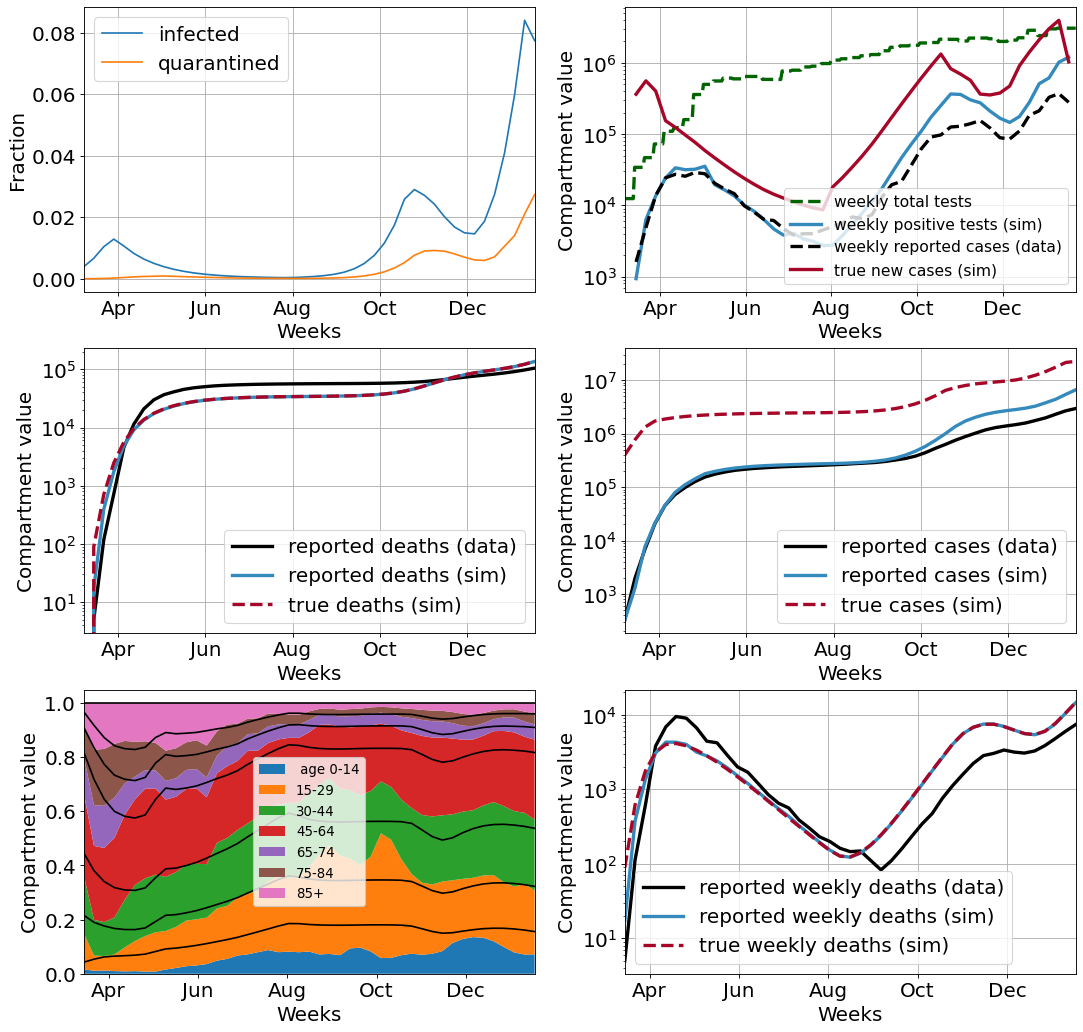

{'a2': 0.46, 'a3': 1.85, 'a4': 1.32, 'a5': 1.1, 'a6': 0.65, 'a7': 0.9, 'a8': 1.6, 'a9': 1.2, 'a10': 0.5, 's2': 0.1, 's4': 0.8, 's5': 0.5, 's6': 0.5, 's7': 0.5, 's8': 0.5, 's9': 0.5, 's10': 0.5, 'sh45': 0.5, 'sh65': 0.7}


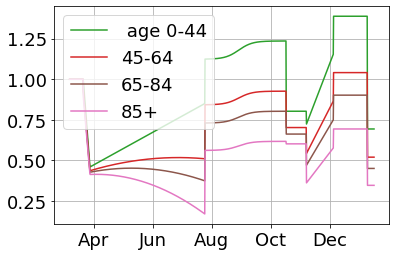

In [26]:
# fraction of asymptomatic cases
alpha = np.array([0.58, 0.43, 0.31, 0.23, 0.17, 0.14, 0.11])  

# Initial conditions as an array
NiQ0 = cases0
cases1=cases0.copy()
E0 = 300*cases1/(1-alpha)
A0 = 200* cases1/(1-alpha)
Ia0 = 300 * cases1/(1-alpha)
Is0 = 50 * cases1/(1-alpha)
zeros=np.zeros(M)

S0 = Ni-NiQ0-E0-A0-Ia0-Is0-12*zeros
#                   "S","E", "A", "Ia", "Is1", "Is2",  Im",  "R", "AQ",  "IaQ", "Is1Q", "Is2Q", "ImQ", "RQ"
x0 = np.concatenate((S0, E0, A0,  Ia0,  Is0, zeros, zeros, zeros, zeros, zeros, NiQ0,  zeros,   zeros, zeros))
    

# duration of simulation and data file
Tf = 45;  Nf=Tf+1; 



beta  = 0.07 # infection rate 
beta_late_factor = 0.1


cfr0_14 = 2e-3
cfr15_29 = 1e-4
cfr30_64 = 2e-3
cfr65_74 = 2e-2
cfr75_84 = 1e-1
cfr85 = 2e-1

t_cfr_change=40
width_cfr_change=40
cfr_change=1

gE    = 7./2.72  # progression rate from E to A
gA    = 7./3.12   # progression rate from A to I
gIa   = 1   # removal rate of asymptomatic infectives
gIs   = 0.5   # removal rate of symptomatic infectives
kE    = 0*cases0/(1-alpha)   # influx of exposeds
kA    = 0*cases0/(1-alpha)   # influx of activateds



sus = np.array([0.5, 0.5, 0.6, 0.8, 1, 1., 5.]) # age-dependent susceptibility

parameters = {
    'beta' : beta*sus,
    'beta_late_factor' : beta_late_factor,
    'gammaE' : gE, 
    'kE' : kE/N,
    'kA' : kA/N,
    'alpha' : alpha, 
    'gammaA' : gA, 
    'gammaIa' : gIa, 
    'cfr0_14' : cfr0_14,
    'cfr15_29' : cfr15_29,
    'cfr30_64' : cfr30_64,
    'cfr65_74' : cfr65_74,
    'cfr75_84' : cfr75_84,
    'cfr85' : cfr85,
    't_cfr_change' : t_cfr_change,
    'width_cfr_change' : width_cfr_change,
    'cfr_change' : cfr_change,
    'gammaIs' : gIs,
    'p_falsepos' : 0.00, # probability of false positives
    'p_truepos'  : 1,  # probability of true positive for infecteds
    'p_trueposE'  : 0.00, # probability of true positive for exposed
    'pi_a_early'      : 0.02,  # fraction of people with flu or cold
    'pi_a_late'      : 0.05,  # fraction of people with flu or cold
    'pi_s'      : 1,     # set to 1 for reference
    'pi_s2_early'      : 5,     # higher priority for severe stage
    'pi_m_early'      : 100,    # priority for testing fatal cases
    'pi_m_late'      : 20, 
    'overdispersion_general': 1,
    'overdispersion_testing': 100,
    'overdispersion_infection': 10,
    'overdispersion_deaths': 50,
    'overdispersion_testing_late': 100,
    'overdispersion_infection_late': 10,
    'overdispersion_deaths_late': 50,
    #'count': [],
    #'counttime': []
}



model = pyross.deterministic.Spp(full_model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)

# generate corresponding contact matrix function
guessed_control_params={
    'a2':0.46, 
    'a3':1.85, 
    'a4':1.32, 
    'a5':1.1, 
    'a6':0.65, 
    'a7':0.9,
    'a8':1.6,
    'a9':1.2,
    'a10':.5,
    's2':0.1,   
    's4':0.8, 
    's5':0.5, 
    's6':0.5, 
    's7':0.5,
    's8':0.5,
    's9':0.5,
    's10':0.5,
    'sh45':0.5, 
    'sh65':0.7
}
contactMatrix = generator.intervention_custom_temporal(intervention_fun, **guessed_control_params)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf, integrator='solve_ivp')


plot_all(data, parameters)
intervention_plot(intervention_fun,Tf, **guessed_control_params)

### Inference

In [27]:
# time for inference (weeks)
Tf_inference = 45

# Load guess from above
inference_parameters = parameters.copy()
x0_g = x0


# set up the observed data in the format required by pyross
obs_cases = cumcases[0:Tf_inference,:].astype('float')
obs_deaths = cumdeaths[0:,:].astype('float')
obs_deaths_tot = np.reshape(deaths_tot[0:Tf_inference],(Tf_inference,1)).astype('float')
obs1 = np.hstack((obs_cases[:len(obs_deaths)],obs_deaths))
obs2 = np.hstack((obs_cases,obs_deaths_tot))

fltr1: observation of age-structured mortality numbers


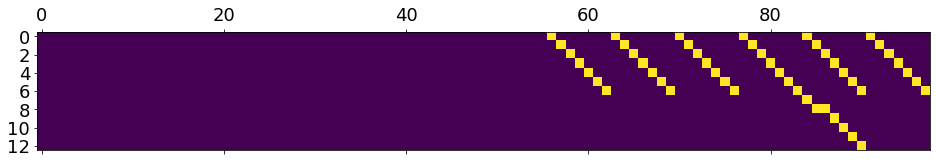

fltr2: observation of total mortality numbers


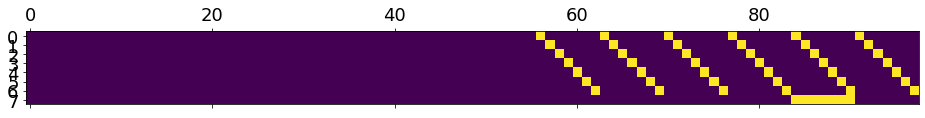

In [28]:
# a filter matrix that extracts all the number of diagnosed individuals for each age group and the total number of confirmed deaths
fltr_cases = np.zeros(model.nClass)
n_gen_class = 8 # No. of classes in generative model
fltr_cases[n_gen_class:] = np.ones(model.nClass-n_gen_class)
fltr_cases = np.kron(fltr_cases,np.identity(M))

fltr_deaths = np.zeros(model.nClass)
fltr_deaths[-2] = 1
fltr_deaths = np.kron(fltr_deaths,np.identity(M))
fltr_deaths[1] += fltr_deaths[2]  # join ages 15-29 and 30-44
fltr_deaths=np.delete(fltr_deaths,2,0)

fltr_deaths_summed = np.zeros(model.nClass)
fltr_deaths_summed[-2] = 1
fltr_deaths_summed = np.repeat(fltr_deaths_summed,M).reshape((1,model.nClass*M))

fltr1=np.vstack((fltr_cases,fltr_deaths))
fltr2=np.vstack((fltr_cases,fltr_deaths_summed))

print('fltr1: observation of age-structured mortality numbers')
plt.matshow(fltr1)
plt.show()
print('fltr2: observation of total mortality numbers')
plt.matshow(fltr2)
plt.show()


In [29]:
# time-dependence of the filter and the observations

# set up filter for initial conditions because they are constrained by the observed 
# note that this filter is different from the bulk of the trajectory, 
# because we assume there are no recovereds/deaths in the beginning and all quarantined cases are infected

#                 S    E    A    Ia   Is1  Is2  Im   R    AQ   IaQ  Is1Q Is2Q ImQ  RQ
fltr0= np.array([[1,   1,   1,   1,   1,   0,   0,   0,   1,   1,   1,   1,   0,   0],    # should sum to Ni
                 [0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],    # 0 severe cases in the beginning
                 [0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    # 0 deaths in the beginning
                 [0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],    # 0 recovered in the beginning
                 [0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],    # 0
                 [0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],    # 0
                 [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],    # initial cases
                 [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0],    # 0
                 [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],    # 0
                 [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1]])   # 0
fltr0 = np.kron(fltr0, np.identity(M))
obs0 = np.concatenate([Ni, np.zeros(5*M), cases0, zeros, zeros, zeros])

# do not observe death numbers while they're zero, otherwise the van Kampen expansion leads to divergences

# the data for the most recent weeks is not age structured

full_obs = np.array([obs0, *(obs1), *(obs2[len(obs1):])])
full_fltrs = np.array([fltr0, *([fltr1]*len(obs1)), *([fltr2]*(Tf_inference-len(obs1)))])


In [30]:
# initialise the estimator 
steps = 4 # minimal number internal integration steps per week
estimator = pyross.inference.Spp(full_model_spec, parameters, M, Ni, 1, steps, lyapunov_method='RK45', det_method='LSODA', 
                                 time_dep_param_mapping=parameter_mapping, rtol_det=1e-8, rtol_lyapunov=1e-3, max_steps_det=50000, max_steps_lyapunov=30000)


In [31]:
# -log-likelihood of initial guess
start = time.time()
print(estimator.minus_logp_red(parameters, x0, full_obs, full_fltrs, Tf_inference, contactMatrix, tangent=False))
end = time.time()
print('elapsed time: ',end - start)

12020.657636710994
elapsed time:  25.049442052841187


In [32]:
# set up prior distribution bounds for each parameter 
eps=1e-5

def myprior(mode, sigma, bounds):  # Gaussian distribution of the log around mode with variance sigma
    mean = mode*np.exp(3*sigma**2/2)
    priordict = {
        'mean': mean,
        'std':  np.sqrt(np.exp(sigma**2)-1) * mean,
        'bounds': bounds
    }
    return priordict


param_priors = {
        'beta':myprior(beta*sus, np.log(1.5), [[eps,10]]*M),

        'cfr0_14':myprior(cfr0_14, np.log(10), [eps,0.3]),
    
        'cfr15_29':myprior(cfr15_29, np.log(10), [eps,0.3]),
    
        'cfr30_64':myprior(cfr30_64, np.log(10), [eps,0.3]),
    
        'cfr65_74':myprior(cfr65_74, np.log(10), [eps,0.3]),
    
        'cfr75_84':myprior(cfr75_84, np.log(10), [eps,0.3]),
    
        'cfr85':myprior(cfr85, np.log(10), [eps,0.3]),
    
        'cfr_change':myprior(1, np.log(3), [eps,3]),
    
        'width_cfr_change':myprior(3, np.log(3), [eps,20]),
    
        't_cfr_change': {
            'mean': 40,
            'std':  2,
            'bounds': [30,44],
            'prior_fun': 'truncnorm'
            },
    
        'pi_a_early':myprior(0.02, np.log(1.2), [eps,1]),
    
        'pi_a_late':myprior(0.05, np.log(1.2), [eps,1]),
    
        'gammaIs':myprior(0.5, np.log(1.5), [0.2,2]),
    
        'a2':myprior(0.46, np.log(2), [eps,1]),
    
        'a3':myprior(1.85, np.log(2), [1,5]),
    
        'a4':myprior(1.32, np.log(2), [1,5]),
    
        'a5':myprior(1.1, np.log(2), [1,5]),
    
        'a6':myprior(0.65, np.log(2), [eps,1]),
    
        'a7':myprior(0.9, np.log(2), [eps,1]),

        'a8':myprior(1.6, np.log(2), [1,5]),
    
        'a9':myprior(1.2, np.log(2), [1,5]),
    
        'a10':myprior(0.5, np.log(2), [eps,1]),
    
        's2':myprior(0.5, np.log(2), [eps, 1]), 
    
        's4':myprior(0.8, np.log(2), [eps, 1]), 
    
        's5':myprior(0.5, np.log(2), [eps, 1]), 
    
        's6':myprior(0.5, np.log(2), [eps, 1]), 
    
        's7':myprior(0.5, np.log(2), [eps, 1]), 
    
        's8':myprior(0.5, np.log(2), [eps, 1]), 
    
        's9':myprior(0.5, np.log(2), [eps, 1]),
    
        's10':myprior(0.5, np.log(2), [eps, 1]),
    
        'sh45':myprior(0.7, np.log(2), [eps, 5]), 
    
        'sh65':myprior(1, np.log(2), [eps, 5]),
     
        't_autumn': {
            'mean': 25,
            'std':  2,
            'bounds': [25,33],
            'prior_fun': 'truncnorm'
            },
    
        'width_autumn': myprior(1, np.log(2), [eps, 10]),
    
        't3': {
            'mean': 28,
            'std':  4,
            'bounds': [20,35],
            'prior_fun': 'truncnorm'
            },
    
        'overdispersion_infection':myprior(10, np.log(1.2), [1,1e5]),
    
        'overdispersion_testing':myprior(100, np.log(100), [1,1e5]),
    
        'overdispersion_deaths':myprior(100, np.log(100), [1,1e5]),
    
        'overdispersion_infection_late':myprior(10, np.log(1.2), [1,1e5]),
    
        'overdispersion_testing_late':myprior(100, np.log(100), [1,1e5]),
    
        'overdispersion_deaths_late':myprior(100, np.log(100), [1,1e5]),
    }

bounds_for_all = np.tile([0.1, 100000], M).reshape(M, 2)
init_fltr = np.repeat([False, True, True, True, True, False, False, False, False, False, False, False, False, False], M)
init_priors = {
        'independent':myprior(np.array([*E0, *A0, *Ia0, *Is0]),np.array([np.log(10)]*(4*M)),[*bounds_for_all, *bounds_for_all, *bounds_for_all, *bounds_for_all])
    }
init_priors['independent']['fltr'] = init_fltr
dill.dump_session('for_HPC.db')  # save session and run the next cell on HPC cluster

In [33]:
# Just to try out. Should be run with more steps on HPC cluster

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  (default 1e-6)
cma_population = 32 # default 128
local_max_iter = 1 # default 2000
global_max_iter = 5 # default 1000
cma_processes = 8   # default 64



start = time.time()
res = estimator.latent_infer(full_obs, full_fltrs, Tf_inference, param_priors, init_priors,  generator=generator,
                                intervention_fun=intervention_fun, global_max_iter=global_max_iter, global_atol=0.5, 
                                verbose=True, ftol=ftol, cma_population=cma_population, 
                                tangent=False, cma_processes=cma_processes, local_max_iter=local_max_iter,
                                enable_global=True, enable_local=False, cma_random_seed=1, use_mode_as_guess=True)
end = time.time()
print('elapsed time: ',end - start)


Starting global minimisation ...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 75 (seed=1, Fri Aug  6 18:53:28 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 4.439291657936631e+04 1.0e+00 9.35e-01  2e-04  3e+04 1:40.4
    2     64 1.175569811683090e+05 1.0e+00 8.88e-01  2e-04  3e+04 3:20.5
    3     96 2.487410244793118e+04 1.0e+00 8.56e-01  2e-04  3e+04 5:09.1
    4    128 5.747129371250646e+04 1.0e+00 8.32e-01  2e-04  3e+04 7:05.4
    5    160 7.224964181191126e+04 1.0e+00 8.11e-01  2e-04  3e+04 8:53.2
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  24874.10244793118
Starting local minimisation...
elapsed time:  533.2314016819


In [34]:
# load results of full optimiser run
res=np.load('res_BC1.npy', allow_pickle=True).item()

In [35]:
res['log_posterior']

-4216.749925796561

In [36]:
res['log_likelihood']

-3819.8287417269094

In [37]:
inferred_model_params = res['params_dict']
inferred_control_params = res['control_params_dict']

print('\n Inferred model params:')
for (name,val) in inferred_model_params.items():
    print('{0: <25}'.format(name),val)

print('\n Inferred control params:')
for (name,val) in inferred_control_params.items():
    print('{0: <15}'.format(name),val)

x0_estimate = res['x0']
print('\n Inferred initial conditons: ') 
for (name,ndx) in estimator.class_index_dict.items():
    print(name+':\t', x0_estimate.astype('int')[ndx*M:(ndx+1)*M])


 Inferred model params:
beta                      [0.01629081 0.04496437 0.03818989 0.21839892 0.07155263 0.09542216
 0.43970914]
beta_late_factor          0.1
gammaE                    2.5735294117647056
kE                        [0. 0. 0. 0. 0. 0. 0.]
kA                        [0. 0. 0. 0. 0. 0. 0.]
alpha                     [0.58 0.43 0.31 0.23 0.17 0.14 0.11]
gammaA                    2.2435897435897436
gammaIa                   1
cfr0_14                   1.0000900252845148e-05
cfr15_29                  1.0265706530946037e-05
cfr30_64                  0.0016954548869947206
cfr65_74                  0.02180325324737369
cfr75_84                  0.082703707205524
cfr85                     0.12151188541457282
t_cfr_change              35.351300677804154
width_cfr_change          3.5068231644456564
cfr_change                2.195715874078479
gammaIs                   0.4272415663523316
p_falsepos                0.0
p_truepos                 1
p_trueposE                0.0
pi_a_early 

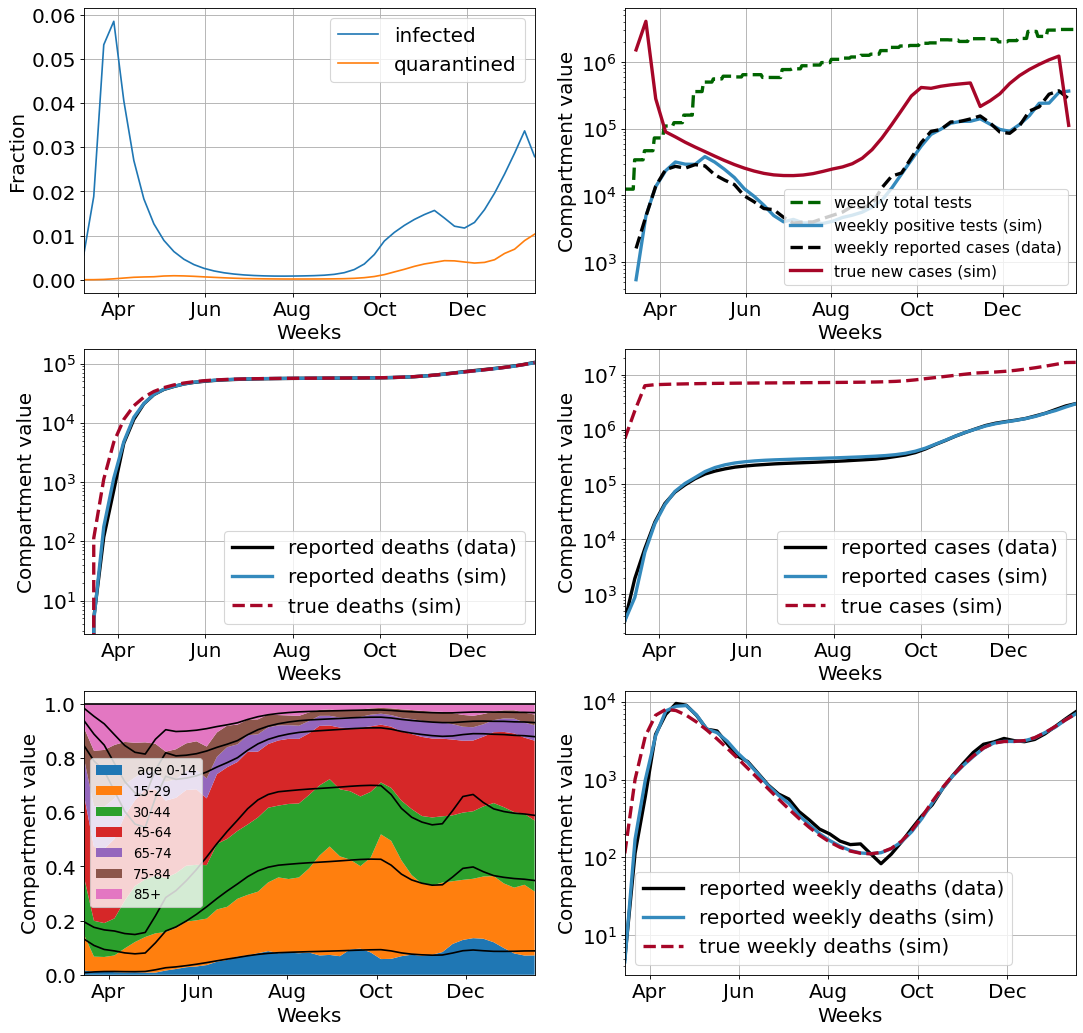

In [38]:
# calculate deterministic soilution with inferred MAP parameters

inferred_contactMatrix = generator.intervention_custom_temporal(intervention_fun, **inferred_control_params)

det_model_inferred = pyross.deterministic.Spp(full_model_spec,inferred_model_params, M, Ni, time_dep_param_mapping=parameter_mapping)
data_inferred = det_model_inferred.simulate(x0_estimate, inferred_contactMatrix, Tf_inference, Tf_inference+1)


plot_all(data_inferred, inferred_model_params)

{'a2': 0.4143418673093562, 'a3': 2.421764280406309, 'a4': 1.007007400411129, 'a5': 1.47514825537643, 'a6': 0.7238880965409222, 'a7': 0.7972248324930136, 'a8': 1.524851866402639, 'a9': 1.0000154149311007, 'a10': 0.2924962558814596, 's2': 0.9999487327858051, 's4': 0.8546920362179768, 's5': 0.8640261468014192, 's6': 0.8611108015845997, 's7': 0.9944708565010488, 's8': 0.7675646647797619, 's9': 0.7939018275121346, 's10': 0.7149662639343073, 'sh45': 1.092507243102636, 'sh65': 0.9181611867770618, 't_autumn': 25.00142053995396, 'width_autumn': 2.3737764812861792, 't3': 29.580422168324382}


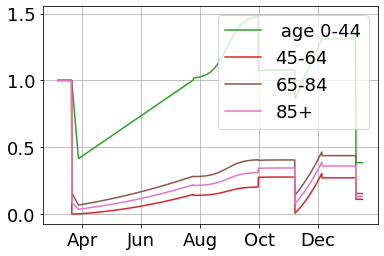

In [39]:
intervention_plot(intervention_fun,Tf, **inferred_control_params)

## Calculate variance around MAP trajectory

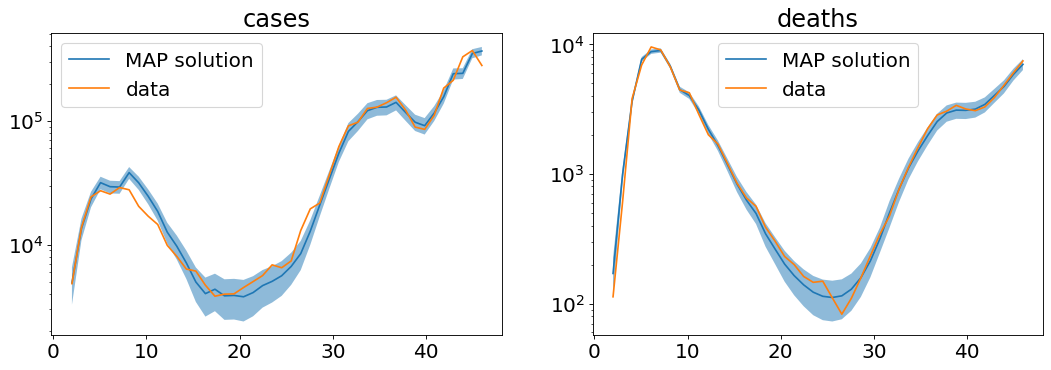

In [42]:
estimator.minus_logp_red(inferred_model_params, x0_estimate, full_obs, full_fltrs, Tf_inference, inferred_contactMatrix, tangent=False)
sol, full_cov= estimator.obtain_full_mean_cov(x0_estimate, Tf_inference, Tf_inference+1)

casevar=np.zeros(Tf_inference-1)
deathvar=np.zeros(Tf_inference-1)
infectedvar=np.zeros(Tf_inference-1)

infected_mask = np.repeat(np.array([0,0,1,1,1,1,0,0,1,1,1,1,0,0],dtype=np.bool),M)

for i in range(Tf_inference-1):
    casevec=np.zeros(full_cov.shape[0])
    casevec[(estimator.dim*i+8*M):(estimator.dim*(i+1))]=-1
    casevec[(estimator.dim*(i+1)+8*M):(estimator.dim*(i+2))]=1
    casevar[i] = np.sqrt(casevec@full_cov@casevec)
    
    deathvec=np.zeros(full_cov.shape[0])
    deathvec[(estimator.dim*i+12*M):(estimator.dim*i+13*M)]=-1
    deathvec[(estimator.dim*(i+1)+12*M):(estimator.dim*(i+1)+13*M)]=1
    deathvar[i] = np.sqrt(deathvec@full_cov@deathvec)
    
    infectedvec=np.zeros(full_cov.shape[0])
    infectedvec[(estimator.dim*(i+1)):(estimator.dim*(i+2))]=infected_mask
    infectedvar[i] = np.sqrt(infectedvec@full_cov@infectedvec)
    
casesol=np.diff(np.sum(sol[:,(8*M):],axis=1))
deathsol=np.diff(np.sum(sol[:,(12*M):(13*M)],axis=1))
infectedsol=np.sum(np.array(sol)[:,infected_mask],axis=1)[1:]

# Cases
t=np.linspace(2,Tf_inference+1,Tf_inference-1)

fig = plt.figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 18})
plt.subplot(1, 2, 1)
plt.fill_between(t,casesol-casevar,casesol+casevar, alpha=0.5)
plt.semilogy(t,casesol,label="MAP solution")
plt.semilogy(t,np.sum(cases[1:Tf_inference,:],axis=1),label="data")
plt.legend()
plt.title('cases')

# Deaths
plt.subplot(1, 2, 2)
plt.fill_between(t,deathsol-deathvar,deathsol+deathvar, alpha=0.5)
plt.semilogy(t,deathsol,label="MAP solution")
plt.semilogy(t,np.diff(deaths_tot[:Tf_inference]),label="data")
plt.legend()
plt.title('deaths')
plt.show()